In [1]:
import datetime

import numpy as np
import pandas as pd

from traffic.core import Traffic, Flight
from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_pers, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import linkage_cluster_persistances, flights_from_query

from scipy.cluster.hierarchy import fcluster

In [2]:
# load minimum data set
df = pd.read_csv("data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2019, month=1, day=15).replace(
    tzinfo=datetime.timezone.utc
)

with_GA = df.query(f"has_ga & (@start <= time <= @stop)")
without_GA = df.query(f"not has_ga & (@start <= time <= @stop)")

In [3]:
# The flights can be converted into a Traffic object
count = with_GA.shape[0]
with_GA_flights = flights_from_query(with_GA, count, "data/with_GA_flights.pkl")
without_GA_flights = flights_from_query(without_GA, count, "data/without_GA_flights.pkl")

In [4]:
with_GA_flights = list(filter(large_gap_filter, with_GA_flights))
without_GA_flights = list(filter(large_gap_filter, without_GA_flights))

with_GA_labels = np.ones(len(with_GA_flights))
without_GA_labels = np.zeros(len(without_GA_flights))

flights = with_GA_flights + without_GA_flights
labels = np.concatenate((with_GA_labels, without_GA_labels))

trees = flight_pers(flights)

100%|██████████| 1389/1389 [00:23<00:00, 58.07it/s]


In [5]:
print(len(with_GA_flights))
print(len(without_GA_flights))

705
684


In [6]:
Z = linkage_cluster_persistances(trees, file_name="cyclic_dataset", load_results=True)

100%|██████████| 1389/1389 [07:22<00:00,  3.14it/s] 


In [7]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 2
2: 7
3: 4
4: 1352
5: 18
6: 2
7: 1
8: 1
9: 1
10: 1


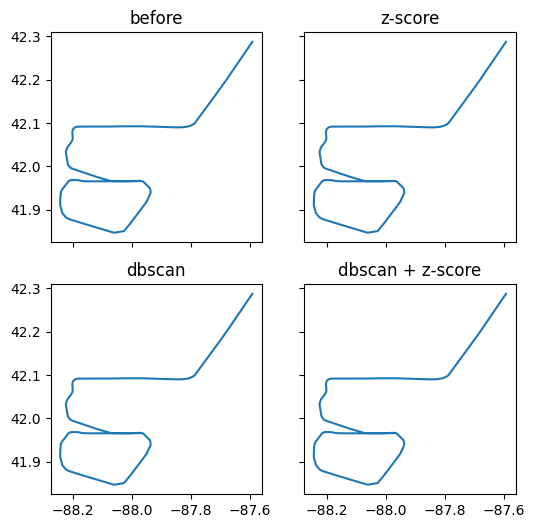

In [50]:
from matplotlib import pyplot as plt

flight = flights[np.where(clustering == 5)[0][0]]
before = flight.data[["longitude", "latitude"]].to_numpy()

dbscan_paths        = before[remove_outliers_dbscan(before)]
z_score_paths       = before[remove_outliers_z_score(before)]
both_bethods_paths  = dbscan_paths[remove_outliers_z_score(dbscan_paths)]

paths = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan"), (both_bethods_paths, "dbscan + z-score")]

fig, axs = plt.subplots((len(paths)+1)//2, 2, sharex=True, sharey=True)
for i, (path, name) in enumerate(paths):
    axs[i//2, i%2].plot(path[:, 0], path[:, 1])
    axs[i//2][i%2].set_title(name)

fig.set_figheight(6)
fig.set_figwidth(6)